In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def load_data(data_dir, img_size=(128, 128)):
    images = []
    masks = []

    for img_file in os.listdir(data_dir):
        if '_mask' not in img_file:
            img_path = os.path.join(data_dir, img_file)
            mask_path = os.path.join(data_dir, img_file.replace(".jpg", "_mask.jpg"))

            img = load_img(img_path, target_size=img_size)
            mask = load_img(mask_path, target_size=img_size, color_mode = 'grayscale')

            img = img_to_array(img) / 255.0
            mask = img_to_array(mask) / 255.0

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

In [3]:
train_dir = '/kaggle/input/bp-datasets/split_datasets/train'
val_dir = '/kaggle/input/bp-datasets/split_datasets/val'
test_dir = '/kaggle/input/bp-datasets/split_datasets/test'

X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(val_dir)
X_test, y_test = load_data(test_dir)

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(608, 128, 128, 3)
(608, 128, 128, 1)
(110, 128, 128, 3)
(110, 128, 128, 1)
(55, 128, 128, 3)
(55, 128, 128, 1)


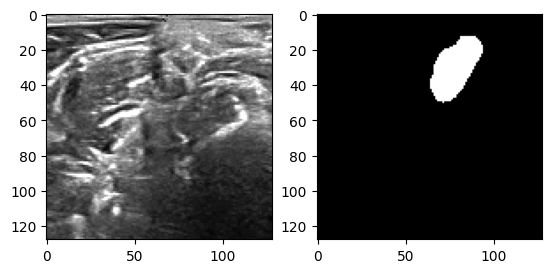

In [5]:
plt.subplot(1, 2, 1)
plt.imshow(X_train[100], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(y_train[100], cmap='gray')


In [6]:
# 데이터 증강
data_gen_args = dict(rotation_range=15,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
image_generator = image_datagen.flow(X_train, seed=seed)
mask_generator = mask_datagen.flow(y_train, seed=seed)
train_generator = zip(image_generator, mask_generator)


In [7]:
# U-Net 모델 정의 (Depth-wise Separable Convolution 적용)
def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    conv1 = layers.SeparableConv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.SeparableConv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.SeparableConv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.SeparableConv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.SeparableConv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.SeparableConv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.SeparableConv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.SeparableConv2D(256, 3, activation='relu', padding='same')(conv4)

    up7 = layers.concatenate([layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv7 = layers.SeparableConv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = layers.SeparableConv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = layers.concatenate([layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.SeparableConv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = layers.SeparableConv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = layers.concatenate([layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.SeparableConv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = layers.SeparableConv2D(32, 3, activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [8]:
model = build_unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 128, 128, 32)   │            155 │ input_layer[0][0]      │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 128, 128, 32)   │          1,344 │ separable_conv2d[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ separable_conv2d_1[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 64, 64, 64)     │          2,400 │ max_pooling2d[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 64, 64, 64)     │          4,736 │ separable_conv2d_2[0]… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ separable_conv2d_3[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_4        │ (None, 32, 32, 128)    │          8,896 │ max_pooling2d_1[0][0]  │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_5        │ (None, 32, 32, 128)    │         17,664 │ separable_conv2d_4[0]… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 128)    │              0 │ separable_conv2d_5[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_6        │ (None, 16, 16, 256)    │         34,176 │ max_pooling2d_2[0][0]  │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_7        │ (None, 16, 16, 256)    │         68,096 │ separable_conv2d_6[0]… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 128)    │        131,200 │ separable_conv2d_7[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concaten

 Total params: 380,764 (1.45 MB)

 Trainable params: 380,764 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 손실 함수 및 메트릭 정의
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, dtype=tf.int32)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    intersection = tf.cast(intersection, dtype=tf.float32)

    y_true = tf.reduce_sum(y_true)
    y_pred = tf.reduce_sum(y_pred)

    result = (2.0 * intersection + smooth) / (y_true + y_pred + smooth)

    return result

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred, a=0.95):
    logit_loss_value = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)
    dice_loss_value = dice_loss(y_true, y_pred)
    
    return a * dice_loss_value + (1 - a) * logit_loss_value


In [10]:
model.compile(optimizer='adam',
             loss= combined_loss,
             metrics=[dice_coef])

In [11]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor= 'val_dice_coef',
    factor=0.9,
    patzence=3,
    min_lr=1e-6,
    mode='max',
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_unet_model.keras',
    monitor='val_dice_coef',
    save_best_only=True,
    mode ='max',
    verbose=1
)

In [12]:
history = model.fit(X_train, y_train,
                   batch_size=8,
                   epochs=100,
                   validation_data=(X_val, y_val),
                   callbacks=[reduce_lr, model_checkpoint]
                   )

Epoch 1/100
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - dice_coef: 0.0039 - loss: 0.9775
Epoch 1: val_dice_coef improved from -inf to 0.00000, saving model to best_unet_model.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - dice_coef: 0.0038 - loss: 0.9773 - val_dice_coef: 2.3690e-10 - val_loss: 0.9582 - learning_rate: 0.0010
Epoch 2/100
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - dice_coef: 2.5710e-10 - loss: 0.9571
Epoch 2: val_dice_coef did not improve from 0.00000
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - dice_coef: 2.5696e-10 - loss: 0.9571 - val_dice_coef: 2.3690e-10 - val_loss: 0.9573 - learning_rate: 0.0010
Epoch 3/100
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - dice_coef: 2.5472e-10 - loss: 0.9567
Epoch 3: val_dice_coef did not improve from 0.00000
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - dice_coef: 2.5467e-10 - loss: 0.9567 - val_dice_coef: 2.3690e-10 - val_loss: 0.9570 - learning_rate: 0.0010
Epoch 4/100
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - dice_coef: 2.5605e-10 - loss: 0.95

In [13]:
best_model = tf.keras.models.load_model('best_unet_model.keras',
                                            custom_objects={
                                            'combined_loss': combined_loss,
                                            'dice_coef': dice_coef})

test_loss, test_dice = best_model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - dice_coef: 0.3206 - loss: 0.6527


In [14]:
model.save('build_depth_unet.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('build_depth_unet.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpw5knx4k_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None)
Captures:
  135416367525280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416367746384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416367747088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416367747968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416367743744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416367749552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416367752192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416367752544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416367753600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135416367755712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1354

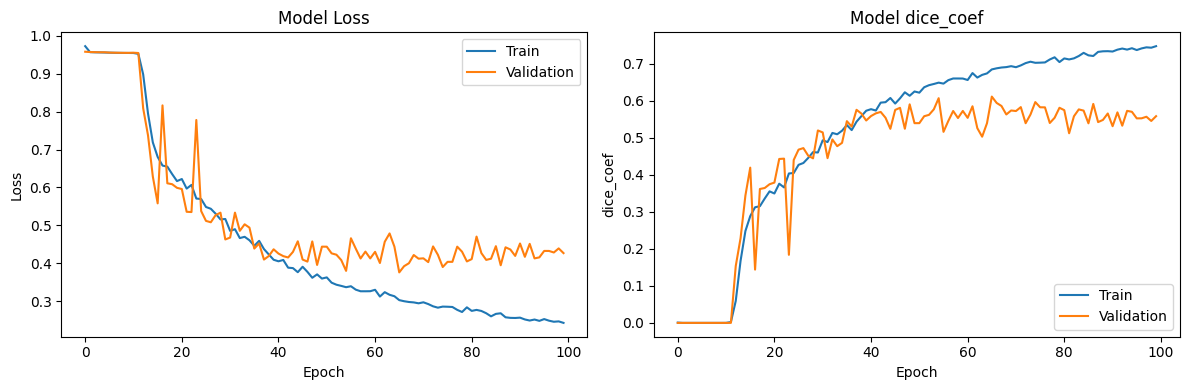

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


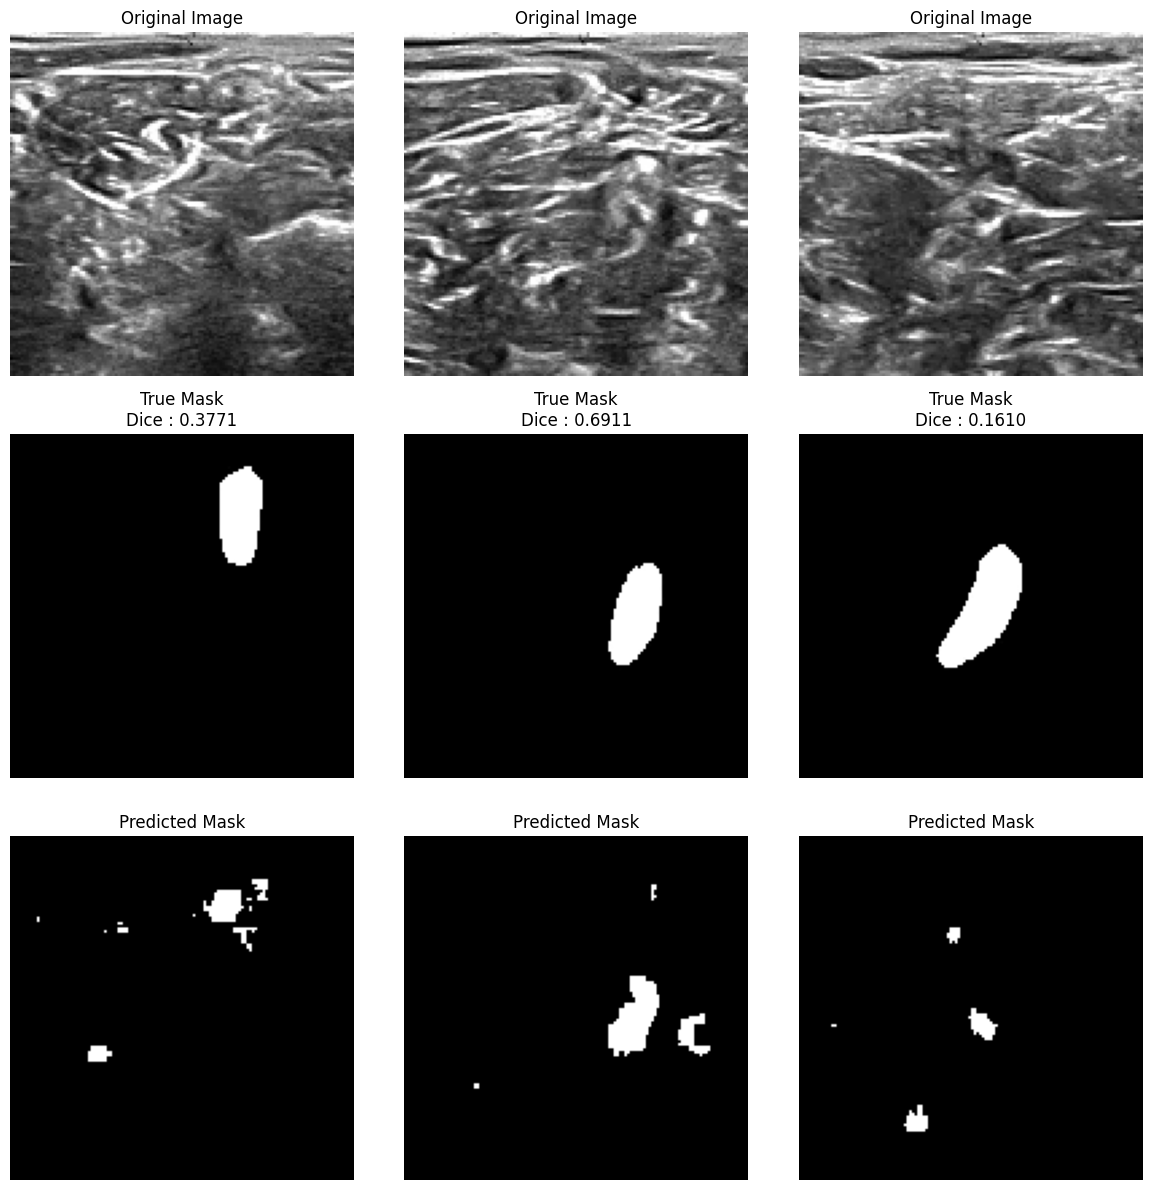

In [16]:
def visualize_results(model, X, y, num_samples=3):
    predictions = model.predict(X[:num_samples])

    predictions = (predictions > 0.5).astype(np.float32)

    plt.figure(figsize=(4*num_samples, 12))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i+1)
        plt.imshow(X[i])
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(y[i, :, :, 0], cmap='gray')
        plt.title(f'True Mask\nDice : {dice_coef(y[i:i+1], predictions[i:i+1]).numpy():.4f}')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + 2*num_samples)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_results(model, X_test, y_test)